In [0]:
import os
import json

In [0]:

# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 6.2MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=299ca3649aef43dc26f12da8e811c8b25526c451492124459907e734edcd0f80
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-qrqjhxs3
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-qrqjhxs3
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [0]:
# install detectron2:
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
     |████████████████████████████████| 6.2MB 712kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post200513-cp36-none-any.whl size=40893 sha256=9aa0320eddc133b653901fce4880253efc12b3da1fb8e69c94d6f8ef5b9e8a44
  Stored in directory: /root/.cache/pip/wheels/a2/f6/77/551770c4b8cd75e9335cd0acf59c08d60a8684048b19da6702
Successfully built fvcore


In [0]:

# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [0]:
os.chdir("/content/drive/My Drive/DrawnAI/")

In [0]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/My Drive/DrawnAI/data/train/coco_train_v1.json", "/content/drive/My Drive/DrawnAI/data/train/train_images/")
register_coco_instances("my_dataset_val", {}, "/content/drive/My Drive/DrawnAI/data/train/coco_val_v1.json", "/content/drive/My Drive/DrawnAI/data/train/train_images/")

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 22  # only has one class (ballon)



Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [0]:
pwd

'/content/drive/My Drive/DrawnAI'

In [0]:
cfg.OUTPUT_DIR = "./output/retinanet_R_101_FPN_3x_1500epochs_22classes/"

In [0]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)


[05/21 15:32:49 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

In [0]:
trainer.train()

[05/21 15:33:00 d2.engine.train_loop]: Starting training from iteration 0
[05/21 15:34:20 d2.utils.events]:  eta: 0:48:58  iter: 19  total_loss: 3.197  loss_cls: 2.646  loss_box_reg: 0.573  time: 2.0106  data_time: 2.0300  lr: 0.000005  max_mem: 4362M
[05/21 15:34:59 d2.utils.events]:  eta: 0:47:29  iter: 39  total_loss: 2.218  loss_cls: 1.771  loss_box_reg: 0.371  time: 1.9964  data_time: 0.0134  lr: 0.000010  max_mem: 4450M
[05/21 15:35:38 d2.utils.events]:  eta: 0:46:09  iter: 59  total_loss: 1.353  loss_cls: 1.024  loss_box_reg: 0.322  time: 1.9732  data_time: 0.0063  lr: 0.000015  max_mem: 4450M
[05/21 15:36:18 d2.utils.events]:  eta: 0:45:52  iter: 79  total_loss: 1.208  loss_cls: 0.993  loss_box_reg: 0.207  time: 1.9782  data_time: 0.0093  lr: 0.000020  max_mem: 4564M
[05/21 15:36:58 d2.utils.events]:  eta: 0:45:30  iter: 99  total_loss: 1.091  loss_cls: 0.738  loss_box_reg: 0.296  time: 1.9859  data_time: 0.0067  lr: 0.000025  max_mem: 4564M
[05/21 15:37:38 d2.utils.events]:  e

In [0]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Output hidden; open in https://colab.research.google.com to view.

In [0]:
type(trainer.model)

detectron2.modeling.meta_arch.retinanet.RetinaNet

In [0]:
trainer.model

RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock(


In [0]:
cfg.OUTPUT_DIR

'./output/retinanet_R_101_FPN_3x_1500epochs_22classes/'

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_val", )
predictor = DefaultPredictor(cfg)

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
eval_folder = "./output/retinanet_R_101_FPN_3x_1500epochs_22classes/evaluations"
os.makedirs(eval_folder, exist_ok=True)
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/retinanet_R_101_FPN_3x_1500epochs_22classes/evaluations/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
valResults = inference_on_dataset(trainer.model, val_loader, evaluator)


WARNING [05/21 16:31:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/21 16:31:09 d2.data.datasets.coco]: Loaded 472 images in COCO format from /content/drive/My Drive/DrawnAI/data/train/coco_val_v1.json
[05/21 16:31:09 d2.data.build]: Distribution of instances among all 21 categories:
|  category   | #instances   |  category  | #instances   |   category   | #instances   |
|:-----------:|:-------------|:----------:|:-------------|:------------:|:-------------|
|  paragraph  | 2051         |  dropdown  | 259          |   checkbox   | 119          |
| radiobutton | 67           |   rating   | 11           |    toggle    | 44           |
|  textarea   | 12           | datepicker | 8            | stepperinput | 1            |
|   slider    | 14           |   video    | 86           |    label     | 296          |
|    table    | 8            |    list    | 170          |    header    | 840          |
|   button    | 35

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 283 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34853 had too many entries: 10, expected 1
  % (tag, len(values))


[05/21 16:32:05 d2.evaluation.evaluator]: Inference done 92/472. 0.5821 s / img. ETA=0:03:43
[05/21 16:32:10 d2.evaluation.evaluator]: Inference done 101/472. 0.5797 s / img. ETA=0:03:36
[05/21 16:32:15 d2.evaluation.evaluator]: Inference done 110/472. 0.5785 s / img. ETA=0:03:31
[05/21 16:32:20 d2.evaluation.evaluator]: Inference done 119/472. 0.5767 s / img. ETA=0:03:25
[05/21 16:32:25 d2.evaluation.evaluator]: Inference done 128/472. 0.5759 s / img. ETA=0:03:19
[05/21 16:32:30 d2.evaluation.evaluator]: Inference done 137/472. 0.5757 s / img. ETA=0:03:14
[05/21 16:32:35 d2.evaluation.evaluator]: Inference done 146/472. 0.5766 s / img. ETA=0:03:09
[05/21 16:32:41 d2.evaluation.evaluator]: Inference done 155/472. 0.5768 s / img. ETA=0:03:04
[05/21 16:32:46 d2.evaluation.evaluator]: Inference done 164/472. 0.5764 s / img. ETA=0:02:58
[05/21 16:32:51 d2.evaluation.evaluator]: Inference done 173/472. 0.5758 s / img. ETA=0:02:53
[05/21 16:32:56 d2.evaluation.evaluator]: Inference done 182/

AssertionError: ignored

In [0]:
val_dict = dict(valResults)

In [0]:
val_dict

{'bbox': {'AP': 41.896543940534684,
  'AP-button': 71.5326732438337,
  'AP-checkbox': 52.481239244392086,
  'AP-container': 72.95450287988669,
  'AP-datepicker': 3.8613861386138613,
  'AP-dropdown': 66.87017357038111,
  'AP-header': 57.23146123426156,
  'AP-image': 72.98712904594787,
  'AP-label': 55.38772464395123,
  'AP-linebreak': 44.18117075261919,
  'AP-link': 64.4630996957447,
  'AP-list': 22.230311606630586,
  'AP-paragraph': 42.21032292063649,
  'AP-radiobutton': 45.90883396777306,
  'AP-rating': 0.0,
  'AP-slider': 19.36633663366337,
  'AP-stepperinput': 0.0,
  'AP-table': 0.0,
  'AP-textarea': 0.0,
  'AP-textinput': 74.32950692757272,
  'AP-toggle': 66.26620517505336,
  'AP-video': 47.56534507026667,
  'AP50': 65.0408589095955,
  'AP75': 47.083290173539424,
  'APl': 46.03354978606884,
  'APm': 40.14469032958786,
  'APs': 25.484759060443203}}

In [0]:
with open('./output/NewMASKRCNN_10000epochs/evaluations/APScores.json', 'w') as fp:
    json.dump(val_dict, fp)

In [0]:
from detectron2.modeling import build_model
model_usingbuild = build_model(cfg) 

In [0]:
model_usingbuild.state_dict()

OrderedDict([('pixel_mean', tensor([[[103.5300]],
              
                      [[116.2800]],
              
                      [[123.6750]]], device='cuda:0')),
             ('pixel_std', tensor([[[1.]],
              
                      [[1.]],
              
                      [[1.]]], device='cuda:0')),
             ('backbone.fpn_lateral2.weight', tensor([[[[ 0.0099]],
              
                       [[ 0.0448]],
              
                       [[-0.0525]],
              
                       ...,
              
                       [[-0.0675]],
              
                       [[-0.0969]],
              
                       [[ 0.0577]]],
              
              
                      [[[ 0.0328]],
              
                       [[ 0.0020]],
              
                       [[-0.0107]],
              
                       ...,
              
                       [[-0.0943]],
              
                       [[-0.099

In [0]:
type(model_usingbuild)

detectron2.modeling.meta_arch.rcnn.GeneralizedRCNN

In [0]:
from detectron2.checkpoint import DetectionCheckpointer
checkpointer = DetectionCheckpointer(model_usingbuild, save_dir="./output/NewMASKRCNN_10000epochs/")
checkpointer.save("model_manualSave_10000epochs")

In [0]:
predictor = DefaultPredictor(cfg)

In [0]:
os.chdir("/content/drive/My Drive/FoodSegmentation/data/val/test_images/images/")
countr = 0
for i in os.listdir():
  if(countr==5):
    break
  else:
    if('_' in i):
      img_path = "/content/drive/My Drive/FoodSegmentation/data/val/test_images/images/" + str(i[2:])
      print(img_path)
    else:
      img_path ="/content/drive/My Drive/FoodSegmentation/data/val/test_images/images/" + str(i)
      print(img_path)
  im = cv2.imread(img_path)
  outputs = predictor(im)
  print(i," ",outputs)
  countr+=1  

/content/drive/My Drive/FoodSegmentation/data/val/test_images/images/057781.jpg
057781.jpg   {'instances': Instances(num_instances=1, image_height=479, image_width=480, fields=[pred_boxes: Boxes(tensor([[ 52.0807, 181.5791, 307.6136, 444.5285]], device='cuda:0')), scores: tensor([0.6864], device='cuda:0'), pred_classes: tensor([1], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
/content/drive/My Drive/FoodSegmentation/data/val/test_images/images/039225.jpg
._039225.jpg   {'instances': Instances(num_instances=1, image_height=479, image_width=479, fields=[pred_boxes: Boxes(tensor([[ 84.0438,  47.5140, 415.8957, 442.7727]]

In [0]:
#SINGLE IMAGE INFERENCE
img_path = "/content/drive/My Drive/FoodSegmentation/data/val/images/019453.jpg"
im = cv2.imread(img_path)
outputs = predictor(im)

In [0]:
outputs.keys()

dict_keys(['instances'])

In [0]:
outputs['instances']

Instances(num_instances=1, image_height=479, image_width=479, fields=[pred_boxes: Boxes(tensor([[ 87.2579,  84.0740, 369.0916, 410.9434]], device='cuda:0')), scores: tensor([0.6791], device='cuda:0'), pred_classes: tensor([46], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])

In [0]:
type(outputs['instances'])

detectron2.structures.instances.Instances

In [0]:
instances = outputs['instances']

In [0]:
instances.pred_masks

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')

In [0]:
instances.pred_masks.shape

torch.Size([1, 479, 479])

In [0]:
instances.pred_masks

In [0]:
torch.set_printoptions(profile="full")
# print(tensor_name)
torch.set_printoptions(profile="default")


In [0]:
instances.pred_masks.

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:

with open('/content/drive/My Drive/FoodSegmentation/data/train/annotations.json') as json_file:
    train_anno = json.load(json_file)

In [0]:
train_anno.keys()

dict_keys(['categories', 'info', 'images', 'annotations'])

In [0]:
train_anno['images'][0]

{'file_name': '065561.jpg', 'height': 464, 'id': 65561, 'width': 464}

In [0]:
train_anno['categories'][0]

{'id': 2578,
 'name': 'water',
 'name_readable': 'Water',
 'supercategory': 'food'}

{'id': 2578, 'name': 'water', 'name_readable': 'Water', 'supercategory': 'food'}


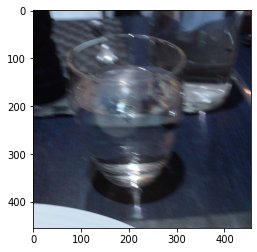

In [0]:
#Only in Training Data
target_image = "073508.jpg"
for i in train_anno['images']:
  if(i['file_name']== target_image):
    img_id = i['id']
    break
category_id_list = []    
for i in train_anno['annotations']:
  if(i['image_id']==img_id):
    # print(i['category_id'])
    category_id_list.append(i['category_id'])
for i in category_id_list:
  for j in train_anno['categories']:
    if(i==j['id']):
      print(j)
img_path = "/content/drive/My Drive/FoodSegmentation/data/train/images/" + target_image
im = cv2.imread(img_path)
plt.imshow(im)      

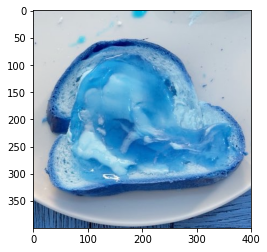

In [0]:
img_path  ="/content/drive/My Drive/FoodSegmentation/data/train/images/071597.jpg"
im = cv2.imread(img_path)
plt.imshow(im)


In [0]:
#OUTPUT FOLDER CONTENTS: 


In [0]:
os.listdir()

['events.out.tfevents.1589133190.7b84ba666805.126.0',
 'events.out.tfevents.1589133363.7b84ba666805.126.1',
 'model_final.pth',
 'last_checkpoint',
 'metrics.json',
 'instances_predictions.pth',
 'coco_instances_results.json']

In [0]:
val_loader

In [0]:
coco_res

[{'bbox': [108.28511810302734,
   42.07478332519531,
   290.4036560058594,
   383.92523193359375],
  'category_id': 1040,
  'image_id': 6508,
  'score': 0.38567063212394714,
  'segmentation': {'counts': 'dn]1b2W:f0C<D;L2N2N2N2N2M3N2N2O1O1N2N3M2O2M2N2O0O2N2O0O2O00001O00001O00001N1010O0001O001O001O1O001O00000010O0001O0000001O0O10001O0O10001N100O10001N100O100O100O1N2O1N2N2O2M2O1O1N2O1O100O100O1O100O100O100O1O1O001O1O1N2O1N10100O100O100O100O10000N110O10O0100O10O01000O1000O010000O1000000O01000O01000O0100O0100000O1000000000000000000001O01O01O00010O0000100O001O10O01O100O2O2N3L3N5K6J5K6J3M010OO010O10O01O10O01O10O10O10001O000O2O1O1O2N1NO2O1O001O1N101O1O0O3L3M4L3N3L3N2M3M3M3M3E;F:H8I7H9J7K4M3L5L3M4K4M3L4M3K5L5K4M3L4M2N1O2M3N2M2O2N2N3M2N4L5Jbod0',
   'size': [426, 426]}},
 {'bbox': [122.56916046142578,
   194.45819091796875,
   243.11346435546875,
   123.70870971679688],
  'category_id': 1069,
  'image_id': 6508,
  'score': 0.29930293560028076,
  'segmentation': {'counts': 'TWa5', 'size': [426, 4

In [0]:
#Analysing coco_instances_json
os.chdir("/content/drive/My Drive/FoodSegmentation/output/")
with open('coco_instances_results.json') as json_file:
    coco_res= json.load(json_file)
print("Length of coco_instances json ",len(coco_res))    
image_id_dict = {}
for i in coco_res:
  if(i['image_id'] not in image_id_dict):
    image_id_dict[i['image_id']] = 1
  else:
    image_id_dict[i['image_id']]+=1  
total = 0
for key,value in image_id_dict.items():
  total+=value
print("Total number of annotations created by model ",total)  
print("Total number of images ",len(image_id_dict))

Length of coco_instances json  8537
Total number of annotations created by model  8537
Total number of images  418


In [0]:
with open('metrics.json') as json_file:
    metrics = [json.loads(line) for line in json_file]

In [0]:
metrics[0]

{'data_time': 0.20171423900001173,
 'eta_seconds': 762.8367433835217,
 'fast_rcnn/cls_accuracy': 0.0078125,
 'fast_rcnn/false_negative': 0.0,
 'fast_rcnn/fg_cls_accuracy': 0.0,
 'iteration': 19,
 'loss_box_reg': 0.5701081156730652,
 'loss_cls': 4.010193586349487,
 'loss_mask': 0.6941133141517639,
 'loss_rpn_cls': 0.0246115829795599,
 'loss_rpn_loc': 0.015669146087020636,
 'lr': 4.99525e-06,
 'mask_rcnn/accuracy': 0.4851475188289602,
 'mask_rcnn/false_negative': 0.4570163391409394,
 'mask_rcnn/false_positive': 0.6015340374985443,
 'roi_head/num_bg_samples': 110.0,
 'roi_head/num_fg_samples': 18.0,
 'rpn/num_neg_anchors': 250.75,
 'rpn/num_pos_anchors': 5.25,
 'time': 0.5150822035000147,
 'total_loss': 5.330272204941139}

In [0]:
metrics[74]

{'data_time': 0.16444291250002152,
 'eta_seconds': 0.5081671550000237,
 'fast_rcnn/cls_accuracy': 0.857421875,
 'fast_rcnn/false_negative': 0.4996580027359781,
 'fast_rcnn/fg_cls_accuracy': 0.24655172413793103,
 'iteration': 1499,
 'loss_box_reg': 0.5924868285655975,
 'loss_cls': 0.5121508091688156,
 'loss_mask': 0.3794623762369156,
 'loss_rpn_cls': 0.011148503050208092,
 'loss_rpn_loc': 0.008239748887717724,
 'lr': 0.00025,
 'mask_rcnn/accuracy': 0.8109321084779509,
 'mask_rcnn/false_negative': 0.2596050026829606,
 'mask_rcnn/false_positive': 0.10625506055561568,
 'roi_head/num_bg_samples': 105.0,
 'roi_head/num_fg_samples': 23.0,
 'rpn/num_neg_anchors': 251.0,
 'rpn/num_pos_anchors': 5.0,
 'time': 0.5186914175000084,
 'total_loss': 1.6884575486183167}

In [0]:
#instances_predictions.pth is similar to coco_instances_results.json
PATH = "/content/drive/My Drive/FoodSegmentation/output/instances_predictions.pth"
x = torch.load(PATH)
print(len(x))
print(x[0].keys())

418
dict_keys(['image_id', 'instances'])


In [0]:
PATH = "/content/drive/My Drive/FoodSegmentation/output/model_final.pth"
model = torch.load(PATH)

In [0]:
print(type(model))
print(model.keys())
print(model['optimizer'].keys())
print(model['scheduler'].keys())
print(model['iteration'])

<class 'dict'>
dict_keys(['model', 'optimizer', 'scheduler', 'iteration'])
dict_keys(['state', 'param_groups'])
dict_keys(['milestones', 'gamma', 'warmup_factor', 'warmup_iters', 'warmup_method', 'base_lrs', 'last_epoch', '_step_count', '_get_lr_called_within_step', '_last_lr'])
1499


In [0]:
from detectron2.evaluation import DatasetEvaluator
class Counter(DatasetEvaluator):
  def reset(self):
    self.count = 0
  def process(self, inputs, outputs):
    for output in outputs:
      self.count += len(output["instances"])
  def evaluate(self):
    # save self.count somewhere, or print it, or return it.
    print("From Counter : ",self.count)
    return {"count": self.count}

In [0]:
from detectron2.config import get_cfg
os.chdir("/content/drive/My Drive/FoodSegmentation/")
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 61

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_val", )
predictor = DefaultPredictor(cfg)

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

WARNING [05/11 09:59:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/11 09:59:38 d2.data.datasets.coco]: Loaded 418 images in COCO format from /content/drive/My Drive/FoodSegmentation/data/val/annotations.json
[05/11 09:59:38 d2.data.build]: Distribution of instances among all 61 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| potatoes-st.. | 11           | chips-frenc.. | 10           | mixed-veget.. | 15           |
| mixed-salad.. | 7            | leaf-spinach  | 2            | salad-leaf-.. | 31           |
|    avocado    | 14           | french-beans  | 6            |    pickle     | 5            |
|   cucumber    | 6            | sweet-pepper  | 5            |    tomato     | 24           |
|   zucchini    | 4            |    carrot     | 18           | 

In [0]:
from detectron2.engine import DefaultTrainer
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load()

[05/11 10:30:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [0]:
from detectron2.evaluation import DatasetEvaluators
val_results = inference_on_dataset(trainer.model,val_loader,
    DatasetEvaluators([COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/outputnew/"), Counter()]))

[05/11 10:30:42 d2.evaluation.evaluator]: Start inference on 418 images
[05/11 10:30:59 d2.evaluation.evaluator]: Inference done 11/418. 0.2663 s / img. ETA=0:03:18
[05/11 10:31:04 d2.evaluation.evaluator]: Inference done 22/418. 0.2610 s / img. ETA=0:03:05
[05/11 10:31:09 d2.evaluation.evaluator]: Inference done 31/418. 0.2606 s / img. ETA=0:03:13
[05/11 10:31:15 d2.evaluation.evaluator]: Inference done 43/418. 0.2610 s / img. ETA=0:03:03
[05/11 10:31:20 d2.evaluation.evaluator]: Inference done 55/418. 0.2608 s / img. ETA=0:02:53
[05/11 10:31:26 d2.evaluation.evaluator]: Inference done 67/418. 0.2599 s / img. ETA=0:02:44
[05/11 10:31:31 d2.evaluation.evaluator]: Inference done 80/418. 0.2591 s / img. ETA=0:02:34
[05/11 10:31:36 d2.evaluation.evaluator]: Inference done 90/418. 0.2587 s / img. ETA=0:02:33
[05/11 10:31:41 d2.evaluation.evaluator]: Inference done 101/418. 0.2586 s / img. ETA=0:02:28
[05/11 10:31:46 d2.evaluation.evaluator]: Inference done 110/418. 0.2591 s / img. ETA=0:02

In [0]:
val_results

OrderedDict([('bbox',
              {'AP': 0.5913977508861998,
               'AP-almonds': 0.0,
               'AP-apple': 16.59405940594059,
               'AP-avocado': 0.0,
               'AP-banana': 9.257425742574258,
               'AP-beer': 0.0,
               'AP-biscuits': 0.0,
               'AP-boisson-au-glucose-50g': 0.0,
               'AP-bread-french-white-flour': 0.0,
               'AP-bread-sourdough': 0.0,
               'AP-bread-white': 1.9801980198019795,
               'AP-bread-whole-wheat': 0.0,
               'AP-bread-wholemeal': 0.0,
               'AP-broccoli': 0.0,
               'AP-butter': 0.0,
               'AP-carrot': 0.0,
               'AP-cheese': 0.0,
               'AP-chicken': 0.0,
               'AP-chips-french-fries': 0.0,
               'AP-coffee-with-caffeine': 0.0,
               'AP-corn': nan,
               'AP-croissant': 0.0,
               'AP-cucumber': 0.0,
               'AP-dark-chocolate': 0.0,
               'AP-egg': 0

In [0]:
os.chdir("/content/drive/My Drive/FoodSegmentation/")

In [0]:
os.makedirs("./noobfolder", exist_ok=True)


In [0]:
os.chdir("/content/drive/My Drive/FoodSegmentation")

EVALUATING FASTER_RCNN 

In [2]:
!pip uninstall pycocotools -y
!pip install -q git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI

Uninstalling pycocotools-2.0.0:
  Successfully uninstalled pycocotools-2.0.0


In [3]:
!pip install numpy==1.17.0

     |████████████████████████████████| 20.4MB 1.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4


In [2]:
import random
import json
import numpy as np
import argparse
import base64
import glob
import os
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
IMAGES_DIR = "/content/drive/My Drive/DrawnAI/data/train/train_images"
GROUND_TRUTH_ANNOTATION_PATH = "/content/drive/My Drive/DrawnAI/data/train/coco_val_v1.json"
ground_truth_annotations = COCO(GROUND_TRUTH_ANNOTATION_PATH)
submission_file = json.loads(open("/content/drive/My Drive/DrawnAI/output/faster_rcnn_R_50_FPN_3x_5000epochs/evaluations/coco_instances_results.json").read())
results = ground_truth_annotations.loadRes(submission_file)
# cocoEval = COCOeval(ground_truth_annotations, results, 'segm')
# cocoEval.evaluate()
# cocoEval.accumulate()
# cocoEval.summarize()
cocoEval = COCOeval(ground_truth_annotations, results, 'bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()



loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.31s).
Accumulating evaluation results...
DONE (t=0.48s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.419
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.650
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.460
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.168
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.461
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets